## Suppressing qubit dephasing using real-time Hamiltonian estimation 

This notebook discusses a paper involving the operation of quantum dot qubits. It follows this [paper](https://www.nature.com/articles/ncomms6156) from the Yacoby lab in Harvard (PDF also included in the current folder).

In this qubit, there are two control knobs for setting the state of the qubit. The more intuitive of the two is an
electric knob: this controls the relative depth of the two potential wells
(ε, the detuning) and the coupling between the wells (J). The second knob is due to the magnetic field experienced by
the quantum dots. An external field is indeed applied by (typically) a superconducting electromagnet, but this is not
the only contribution. There is also a fluctuating magnetic field $\Delta B_z$ due to the spin of the nuclear spins in the
substrate hosting the quantum dots.

The qubit state precesses around the axis of this magnetic field, and moving to the rotating frame is therefore
desirable to mitigate this decohering effect.  
However, due to fluctuations of the field, it is not possible to simply switch to the rotating frame by modulating the
level of detuning. It is possible, by manipulations of the qubit state, to polarize the substrate (so called -
“pumping”) thus minimizing the fluctuations but this has limited effect as there are residual fluctuations.
Nevertheless, as the rate of fluctuation is slower than the experimental cycle timescale, a protocol to estimate the
magnetic field just before the experiment can be used to switch to the correct rotating frame.

This can be done, for example, by employing Bayesian estimation of the magnetic field. This technique uses a prior by
which all magnetic field values in some range are equally probable and uses Bayes theorem to repeatedly update the (
posterior) distribution. The most probably field of the final distribution is assumed to be the external field for the
duration of the experiment.

To perform Bayesian estimation, a single-shot state evaluation needs to first be performed. This is done in the first
row of the snippet below. The state is measured by measuring the reflection of an RF signal from a Quantum Point
Contact (QPC) near the double-dot. The reflected signal is demodulated and the demodulated value is saved to a variable.
All this is accomplished with just a single statement.

The following expression then needs to be repeatedly evaluated (in real time) for each possible value of magnetic field:

$$P(m_k|\Delta B_z)=\frac{1}{2}[1+r_k (\alpha+\beta cos(2\pi \Delta B_z t_k)]$$

Where $m_k$ is the qubit state ($S$ or $T_0$), $r_k$ is a factor equal to 1 or -1 depending on the state, 
and $t_k$ is the evolution time of the $k^{th}$ measurement. $\alpha$ and $\beta$ are numeric
constants.

This is done in the first `for` loop. Note the usage of casting and trigonometric functions which are efficiently
implemented on the QOP processor. The second `for` loop a normalization of the resulting probability distribution.
The following section implements equations (1)-(4) in the paper: 
```python
measure('measure', 'RF-QPC', None, demod.full('integW1', I))
assign(state[k - 1], I > 0)
save(state[k - 1], state_str)
assign(rk, Cast.to_fixed(state[k - 1]) - 0.5)
with for_(fB, fB_min, fB < fB_max, fB + dfB):
    assign(C, Math.cos2pi(Cast.mul_fixed_by_int(fB, t_samp * k)))
    assign(Pf[ind1], (0.5 + rk * (alpha + beta * C)) * Pf[ind1])
    assign(ind1, ind1 + 1)

assign(norm, 1 / Math.sum(Pf))
with for_(ind1, 0, ind1 < Pf.length(), ind1 + 1):
    assign(Pf[ind1], Pf[ind1] * norm)
```

The maximum value of the resulting vector is then taken as the most probable magnetic
field value, and a target procedure can be run, at a frame rotating with the qubit.
In this script, a time Rabi experiment is run, but any other procedure can be selected.  


2021-04-01 18:23:14,673 - qm - INFO - Performing health check
2021-04-01 18:23:14,676 - qm - INFO - Health check passed
2021-04-01 18:23:15,120 - qm - INFO - Flags: 
2021-04-01 18:23:15,121 - qm - INFO - Simulating Qua program


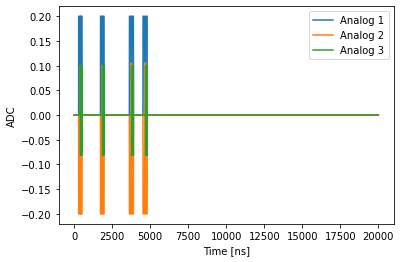

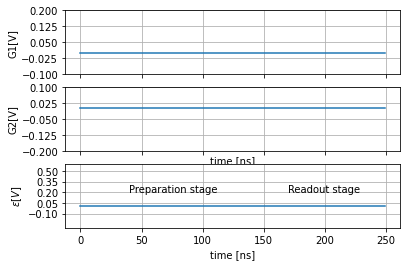

In [2]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
import numpy as np
import matplotlib.pyplot as plt
import time
from configuration import *

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM = qmManager.open_qm(config)  # Generate a Quantum Machine based on the configuration described above

N = 3  # 120
t_samp = 12 // 4
th = 0
fB_min = 50
fB_max = 70
Nf = 2  # 256
N_avg = 2
fB_vec = np.linspace(fB_min, fB_max, Nf)
dfB = np.diff(fB_vec)[0]
alpha = 0.25
beta = 0.67
elements=['DET','D1','D2','RF-QPC','DET_RF']

def prep_stage():
    play('prep', 'D1')
    play('prep', 'D2')
    play('ramp_down_evolve', 'D1')
    play('ramp_up_evolve', 'D2')

def readout_stage():
    play('ramp_up_read', 'D1')
    play('ramp_down_read', 'D2')

    wait(t_samp * k + prep_len // 4 + 2 * ramp_len // 4, 'RF-QPC')
    play('readout', 'D1')
    play('readout', 'D2')
    measure('measure', 'RF-QPC', None, demod.full('integW1', I))


with program() as dephasingProg:
    N_avg = declare(int)
    k = declare(int)
    I = declare(fixed)
    fB = declare(fixed)

    state = declare(bool, size=N)
    state_str = declare_stream()
    rabi_state = declare(bool)
    rabi_state_str = declare_stream()

    ind1 = declare(int, value=0)
    Pf = declare(fixed, value=[1 / len(fB_vec)] * int(len(fB_vec)))
    rk = declare(fixed)
    C = declare(fixed)
    norm = declare(fixed)


    #########################
    # Feedback and Estimate #
    #########################
    update_frequency('DET', 0)

    with for_(k, 2, k <= N, k + 1):

        play('prep','D1')
        play('prep', 'D2')
        play('evolve', 'D1', duration=t_samp * k)
        play('evolve', 'D2', duration=t_samp * k)
        play('readout', 'D1')
        play('readout', 'D2')
        wait(t_samp*k+prep_len//4,'RF-QPC')

        measure('measure', 'RF-QPC', None, demod.full('integW1', I))
        assign(state[k - 1], I > 0)
        save(state[k - 1], state_str)
        assign(rk, Cast.to_fixed(state[k - 1]) - 0.5)
        assign(ind1,0)
        with for_(fB, fB_min, fB < fB_max, fB + dfB):
            assign(C, Math.cos2pi(Cast.mul_fixed_by_int(fB, t_samp * k)))
            assign(Pf[ind1], (0.5 + rk * (alpha + beta * C)) * Pf[ind1])
            assign(ind1, ind1 + 1)

        assign(norm, 1 / Math.sum(Pf))
        with for_(ind1, 0, ind1 < Pf.length(), ind1 + 1):
            assign(Pf[ind1], Pf[ind1] * norm)

    update_frequency('D1_RF', 1e6 * (fB_min + dfB * Math.argmax(Pf)))
    update_frequency('D2_RF', 1e6 * (fB_min + dfB * Math.argmax(Pf)))

    #########
    #Operate#
    #########

    with for_(k, 2, k <= N, k + 1):
        prep_stage()
        wait(prep_len//4+ramp_len//4,'D1_RF')
        wait(prep_len // 4 + ramp_len // 4, 'D2_RF')
        play('const' * amp(0.05), 'D1_RF', duration=t_samp * k)
        play('const' * amp(0.05), 'D2_RF', duration=t_samp * k)
        play('evolve','D1',duration=t_samp * k)
        play('evolve', 'D2', duration=t_samp * k)
        readout_stage()
        assign(rabi_state, I > 0)
        save(rabi_state, rabi_state_str)

    with stream_processing():
        state_str.save_all('state_str')
        rabi_state_str.save_all('rabi_state_str')

job = qmManager.simulate(config, dephasingProg,
                         SimulationConfig(int(5000)))
# res = job.result_handles
# states = res.state_str.fetch_all()['value']
samples = job.get_simulated_samples()
samples.con1.plot()

plt.figure()
# G1=samples.con1.analog['1'][270:550]
# G2=samples.con1.analog['2'][270:550]
G1=samples.con1.analog['1'][1050:1300]
G2=samples.con1.analog['2'][1050:1300]
ax1=plt.subplot(311)
plt.plot(G1)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('G1[V]')
plt.yticks(np.linspace(-0.1,0.2,5))
plt.grid()
ax2=plt.subplot(312,sharex=ax1)
plt.plot(G2)
plt.xlabel('time [ns]')
plt.ylabel('G2[V]')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.yticks(np.linspace(-0.2,0.1,5))
plt.grid()
ax3=plt.subplot(313,sharex=ax1)
plt.plot(G1-G2)
plt.xlabel('time [ns]')
plt.ylabel('$\epsilon [V]$')
plt.ylim([-0.3,0.6])
plt.yticks(np.linspace(-0.1,0.5,5))
plt.text(40,0.2,'Preparation stage')
plt.text(170,0.2,'Readout stage')
plt.grid()
plt.show()